In [ ]:
# Coded By Sayan Chandra
# Roll : CS20M057
# DEEP LEARNING (CS6910) ASSIGNMENT 3
# Instructor : Mitesh M. Khapra  

In [ ]:
def unzip():
    !tar -xf dakshina_dataset_v1.0.tar

In [ ]:
def download():
    !wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

In [ ]:
def setWandb():
    global WANDB
    WANDB=0

In [ ]:
setWandb()
def download_unzip():
    download()
    unzip()
download_unzip()

--2021-05-24 21:12:42--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 142.251.33.208, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  32.2MB/s    in 17s     

2021-05-24 21:12:59 (110 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [ ]:
if WANDB:
   !pip install --upgrade wandb

In [ ]:
if WANDB: 
  !wandb login #952756aa88ee3a472980bceb7d23632ac0a85500

In [ ]:
import numpy as np
import tensorflow as tf

if WANDB:
  import wandb
  from wandb.keras import WandbCallback as WC
  
from tensorflow import keras

In [ ]:
sweep_config={
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_accuracy(word_level)',
        'goal' : 'maximize',
    },
    'parameters' : {

        'input_embedding_size' : {
            'values' : [32, 64, 128],
        },
        'learning_rate' : {
            'values' : [1e-3, 2e-3, 3e-3],
        },
        'dropout' : {
            'values' : [0.2, 0.3, 0.5, 0.3]
        },
        'num_layers': { 
            'values' : [1, 2, 3]
        },
        'hidden_layer_size' : {
            'values' : [128, 512, 256],
        },
        'attention' : {
            'values' : ["yes"]
        },
        'cell_type' : {
            'values' : [ "vanillaRnn", "lstm", "gru"],
        },
        'optimizer' : {
            'values' : ['rmsprop', 'adam', 'sgd'],
        },
        'epochs' : {
            'values' : [6, 17, 13],
        },
        'batch_size' : {
            'values' : [32, 128, 64],
        },

    }
}
if WANDB: sweep_id = wandb.sweep(sweep_config, entity="blackcloud", project="cs6910_dl_assignment_3")

In [ ]:
def eid_did_dtd(qwerty):
  did = np.zeros((len(qwerty), max_decoder_seq_length), dtype="float32") #2D  
  dtd = np.zeros((len(qwerty), max_decoder_seq_length, num_decoder_tokens), dtype="float32") #3D
  eid = np.zeros((len(qwerty), max_encoder_seq_length), dtype="float32") #2D
  return eid, did, dtd

In [ ]:
def bookKeep(qwerty):
    print("global vars are set for training the model.")
    print("Num_samples:", len(qwerty))
    print("# unique input tokens:", num_encoder_tokens) # unique chars in english
    print("# unique output tokens:", num_decoder_tokens) # unique chars in hindi
    print("Max sequence length for inputs:", max_encoder_seq_length) # max wordlen in english
    print("Max sequence length for outputs:", max_decoder_seq_length) # max wordlen in hindi

In [ ]:
# GLOBAL VARS
num_encoder_tokens=0; num_decoder_tokens=0; 
input_token_index={}; target_token_index={}
max_encoder_seq_length=0; max_decoder_seq_length=0;
input_characters=set()
target_characters = set()
##########################################################################################################################

def preprocessing_TrainValTest(dataType, datapath, mode, isTrain, en_format):
  print("preprocessing started for"+dataType)
  global max_encoder_seq_length, max_decoder_seq_length, input_token_index, target_token_index, num_encoder_tokens, num_decoder_tokens, input_characters, target_characters
  input_texts, target_texts = [], []
  with open(datapath, mode, encoding=en_format) as data:
    lines = data.read().split("\n")
  #print(len(lines))
  prev, __, _= lines[0].split("\t"); flag=1
  for iii, line in enumerate(lines[: len(lines) - 1]):
    target_text, input_text, ignore = line.split("\t")
    if iii>0 and target_text==prev : continue;
    prev=target_text
    #if target_text in target_texts : continue
    start = "\t"; end="\n"
    target_text = start + target_text + end ;  input_text = start + input_text + end
    input_texts.append(input_text) ;   target_texts.append(target_text)
    if isTrain:
      for cc in input_text:
          if cc not in input_characters:
              input_characters.add(cc)
      for cc in target_text:
          if cc not in target_characters:
              target_characters.add(cc)


  if isTrain==1:

    input_characters = sorted(list(input_characters))
    input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])

    target_characters = sorted(list(target_characters))
    target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

    num_encoder_tokens = len(input_characters)
    max_encoder_seq_length = max([len(ii) for ii in input_texts])+1

    num_decoder_tokens = len(target_characters)
    max_decoder_seq_length = max([len(ii) for ii in target_texts])+1 

    bookKeep(input_texts)



  encoder_input_data, decoder_input_data, decoder_target_data= eid_did_dtd(input_texts)

  for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t] =  input_token_index[char]
      encoder_input_data[i, t + 1: ] = input_token_index[end]
      for t, char in enumerate(target_text):
          decoder_input_data[i, t] = target_token_index[char]
          if t > 0:
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      decoder_input_data[i, t + 1: ] = target_token_index[end]
      decoder_target_data[i, t:, target_token_index[end]] = 1.0
  print("preprocessing finished for"+dataType+"\n")
  return input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data

In [ ]:
def setPaths():
    aaaaaa="dakshina_dataset_v1.0/hi/lexicons/"
    bbbbbb =  aaaaaa+"hi.translit.sampled.train.tsv"
    cccccc =  aaaaaa+"hi.translit.sampled.dev.tsv"
    dddddd =  aaaaaa+"hi.translit.sampled.test.tsv"
    return aaaaaa, bbbbbb, cccccc, dddddd

In [ ]:
root, train_data_path, val_data_path, test_data_path = setPaths()
input_train_texts, target_train_texts, encoder_input_train_data, decoder_input_train_data, decoder_target_train_data = preprocessing_TrainValTest(" train", train_data_path, mode="r", isTrain=1, en_format="utf-8")
input_val_texts, target_val_texts, encoder_input_val_data, decoder_input_val_data, decoder_target_val_data = preprocessing_TrainValTest(" val" ,val_data_path, mode="r", isTrain=0, en_format="utf-8")
input_test_texts, target_test_texts, encoder_input_test_data, decoder_input_test_data, decoder_target_test_data = preprocessing_TrainValTest(" test" ,test_data_path, mode="r", isTrain=0, en_format="utf-8")

preprocessing started for train
global vars are set for training the model.
Num_samples: 25000
# unique input tokens: 28
# unique output tokens: 65
Max sequence length for inputs: 23
Max sequence length for outputs: 22
preprocessing finished for train

preprocessing started for val
preprocessing finished for val

preprocessing started for test
preprocessing finished for test



In [ ]:
def shapes():
   xx=keras.Input(shape=(max_encoder_seq_length,))
   yy=keras.Input(shape=(max_decoder_seq_length,))
   return xx, yy

def makeModel(xxx, yyy):
   return keras.Model(xxx, yyy)

In [ ]:
# RNN based seq2seq model

keepCells = {"gru":keras.layers.GRU, "lstm":keras.layers.LSTM, "vanillaRnn":keras.layers.SimpleRNN, "embedd":keras.layers.Embedding, 
             "dense":keras.layers.Dense, "attention":keras.layers.AdditiveAttention, "concat":keras.layers.Concatenate}

def ReccNeuralNet(en, input_embedd_sz, latent_dim, drop, cell):
   
    global putEncoders, HiddenStatesOfDecoder, putDecoders, CHECK
    CHECK=0


    # (i) input layer for character embeddings

    encoder_inputs, decoder_inputs=shapes()

    encoder_layer=keepCells["embedd"](input_dim= num_encoder_tokens, output_dim=input_embedd_sz)
    encoder_embedded = encoder_layer(encoder_inputs)
    decoder_layer=keepCells["embedd"](input_dim = num_decoder_tokens, output_dim=input_embedd_sz )
    decoder_embedded=decoder_layer(decoder_inputs)
    # (i) input layer for character embeddings


    putEncoders, putDecoders, HiddenStatesOfDecoder, en = [], [], [], en-1
    de=en



    # (ii) one encoder RNN which sequentially encodes the input character sequence
    if cell=="vanillaRnn":

        ################################################################################################
        encoder = keepCells[cell](latent_dim , return_state=1, return_sequences=1)
        outputs, state_h = encoder(encoder_embedded)
        HiddenStatesOfDecoder.append([state_h])
        putEncoders.append(encoder)

        for i in range(en):
          en_rnn = keepCells[cell](latent_dim , return_state=1, return_sequences=1, dropout=drop)
          outputs, state_h = en_rnn(outputs)
          HiddenStatesOfDecoder.append([state_h])
          putEncoders.append(en_rnn)
        ################################################################################################

    elif cell=="lstm":

        ################################################################################################
        encoder = keepCells[cell](latent_dim , return_state=1, return_sequences=1)
        outputs, state_h, state_c = encoder(encoder_embedded)
        HiddenStatesOfDecoder.append([state_h, state_c])
        putEncoders.append(encoder)
        for i in range(en):
          en_lstm =keepCells[cell](latent_dim , return_state=1, return_sequences=1, dropout=drop)
          outputs, state_h, state_c = en_lstm(outputs)
          HiddenStatesOfDecoder.append([state_h, state_c])
          putEncoders.append(en_lstm)
        ################################################################################################

    elif cell=="gru":

        ################################################################################################
        encoder = keepCells[cell](latent_dim , return_state=1, return_sequences=1)
        outputs, state_h = encoder(encoder_embedded)
        HiddenStatesOfDecoder.append([state_h])
        putEncoders.append(encoder)
        for i in range(en):
          en_gru = keepCells[cell](latent_dim , return_state=1, return_sequences=1, dropout=drop)
          outputs, state_h = en_gru(outputs)
          HiddenStatesOfDecoder.append([state_h])
          putEncoders.append(en_gru)
        ################################################################################################


    # (ii) one encoder RNN which sequentially encodes the input character sequence
     



    # (iii) one decoder RNN which takes the last state of the encoder as input and produces one output character at a time

    if cell=="vanillaRnn":

        ################################################################################################
        decoder_rnn = keepCells[cell](latent_dim, return_sequences=1, return_state=1)
        de_outputs, ignore = decoder_rnn(decoder_embedded, initial_state=HiddenStatesOfDecoder[0])
        putDecoders.append(decoder_rnn)
        for i in range(de):
          de_rnn = keepCells[cell](latent_dim , return_state=1, return_sequences=1, dropout=drop)
          de_outputs, ignore = de_rnn(de_outputs,HiddenStatesOfDecoder[i+1])
          putDecoders.append(de_rnn)
        ################################################################################################

    elif cell=="lstm":

        ################################################################################################
        decoder_lstm = keepCells[cell](latent_dim, return_sequences=1, return_state=1)
        de_outputs, ignore1, ignore2 = decoder_lstm(decoder_embedded, initial_state=HiddenStatesOfDecoder[0])
        putDecoders.append(decoder_lstm)
        for i in range(de):
          de_lstm = keepCells[cell](latent_dim , return_state=1, return_sequences=1, dropout=drop)
          de_outputs, state_h, state_c = de_lstm(de_outputs, initial_state=HiddenStatesOfDecoder[i+1])
          putDecoders.append(de_lstm)
        ################################################################################################

    elif cell=="gru":

        ################################################################################################
        decoder_gru = keepCells[cell](latent_dim, return_sequences=1, return_state=1)
        de_outputs, ignore = decoder_gru(decoder_embedded, initial_state=HiddenStatesOfDecoder[0])
        putDecoders.append(decoder_gru)
        for i in range(de):
          de_gru = keepCells[cell](latent_dim , return_state=1, return_sequences=1, dropout=drop)
          de_outputs, ignore = de_gru(de_outputs, HiddenStatesOfDecoder[i+1])
          putDecoders.append(de_gru)
        ################################################################################################

    # (iii) one decoder RNN which takes the last state of the encoder as input and produces one output character at a time


    # attention layer
    decoder_attention = keepCells["attention"]()
    decoder_concat    = keepCells["concat"]()
    attn1, attn2 = decoder_attention([de_outputs, outputs], return_attention_scores=True)
    de_outputs = decoder_concat([de_outputs, attn1])
    # attention layer
  

    # Dense Layer
    makeDense=keepCells["dense"](num_decoder_tokens, activation="softmax")
    decoder_dense = makeDense
    decoder_outputs = decoder_dense(de_outputs) # None*22*65
    # Dense Layer
    
    #model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model = makeModel([encoder_inputs, decoder_inputs], decoder_outputs)
    return model


In [ ]:
def inferenceModel (mdl, ld, emb_var, attn, cell):
  print("Model has been trained. Making inference model now.")
  ld1,ld2=ld,ld
  input_to_encoder_embed = mdl.layers[0].output
  input_to_decoder_embed = mdl.layers[1].output
  en_embed_layer = mdl.layers[2]
  de_embed_layer = mdl.layers[3]
  en_embed_op = en_embed_layer(input_to_encoder_embed)
  de_embed_op= de_embed_layer(input_to_decoder_embed)
  statesEN = []
  outEN = en_embed_op  
  statesDEinps, statesDE = [], []

  
  for i in range(len(ld1)):
      if cell == 'lstm':
        encoder_lstm = putEncoders[i]
        #print(outEN.shape)
        outEN, state_h, state_c = encoder_lstm(outEN)
        statesEN += [state_h, state_c]
      else:
        #print("yo")
        encoder_gru_rnn = putEncoders[i]
        outEN, state_h = encoder_gru_rnn(outEN)
        statesEN += [state_h]

  inp1=input_to_encoder_embed
  out2=statesEN + [outEN]
  encoder_model = keras.Model(inputs=inp1, outputs = out2)



  for i in range(len(ld2)):
      if cell == 'lstm':
        statesCURinp = [keras.Input(shape=(ld2[i],)) for _ in range(2)]
        de_embed_op, state_h2, state_c2 = putDecoders[i](de_embed_op, initial_state=statesCURinp)
        statesDEinps += statesCURinp
        statesDE += [state_h2 , state_c2]

      else:
        #print("yo")
        statesCURinp = [keras.Input(shape=(ld2[i],)) for _ in range(1)]
        de_embed_op, state_h2=  putDecoders[i](de_embed_op, initial_state=statesCURinp)
        statesDEinps += statesCURinp
        statesDE += [state_h2 ]
        
  
  if attn == "yes":
    print("This model is with attention.")
    attn_layer = mdl.layers[4 + len(ld1) + len(ld2)] 
    hiddenstatesDEinp = keras.Input(shape=(max_encoder_seq_length , ld1[0]))
    #print(hiddenstatesDEinp.shape, de_embed_op.shape)
    attn1, attn2 = attn_layer([de_embed_op, hiddenstatesDEinp], return_attention_scores=True) 

    concate = mdl.layers[4 + len(ld1) + len(ld2) + 1]
    de_embed_op = concate([de_embed_op, attn1])

    inp3=[input_to_decoder_embed] + [hiddenstatesDEinp] + statesDEinps
    out1=[attn2]
    attention_model = keras.Model(inp3, out1)
  
    #Dense layer
    decoder_dense = mdl.layers[4 + len(ld1) + len(ld2) + 2]
    de_embed_op = decoder_dense(de_embed_op) 

    # Define the decoder model
    inp3= [input_to_decoder_embed]  + statesDEinps + [hiddenstatesDEinp]
    out2= [de_embed_op] + [statesDE]
    decoder_model = keras.Model(inp3, out2) 
    print("Inference model is made now.")
    return encoder_model , decoder_model, attention_model


  elif attn == "no":
    print("This model is without attention.")
    #Dense layer
    decoder_dense = mdl.layers[4 + len(ld1) + len(ld2)]
    hiddenstatesDEinp = keras.Input(shape=(max_encoder_seq_length , ld1[0]))
    de_embed_op = decoder_dense(de_embed_op) 

    # Define the decoder model
    inp3=[input_to_decoder_embed]  + statesDEinps + [hiddenstatesDEinp]
    out2=[de_embed_op] + [statesDE]
    decoder_model = keras.Model(inp3, out2) 

    print("Inference model is made now.")
    return encoder_model , decoder_model


In [ ]:
def beam_search(mtrx, k):
    from math import log
    from numpy import array, argmax
    mtrx  = tf.nn.softmax(mtrx)
    sequences = [[list(), 0.0]]
    for eachRow in mtrx:
        family = list()
        for i in range(len(sequences)):
            seq, marks= sequences[i]
            best_k = np.argsort(eachRow)[-k:]
            for j in best_k:
                person = [seq + [j], marks+ tf.math.log(eachRow[j])]
                family.append(person)
        ordered = sorted(family, key=lambda tup:tup[1], reverse=True)
        sequences = ordered[:k]
    return np.array(sequences)[:,0:1]

In [ ]:
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
def charByCharDecoding(input_seq):

    global attentionOut, beamMatrix
    attentionOut=[]; beamMatrix=[] # matrix for keeping probabilities of each char of a particular word

    states_value = encoder_model.predict(input_seq) # predicting whole one-hot-encoded english word using encoder_model

    curChar = np.zeros((1, 1)); start="\t"
    curChar[0, 0] = target_token_index[start]
    # empty target seq curChar with 1st char index = start char index = idx("\t") = 0

    encoder_outputs=states_value[-1]
    encoder_states_value=states_value[:-1]
    # for decoder_model inputs

    stop_condition = False
    while not stop_condition:
        
        output_decoder, decoder_states = decoder_model.predict([curChar] + encoder_states_value + [encoder_outputs])
        # predicting each char using decoder_model sequentially

        attentionOut.append(attention_model.predict([curChar] + [encoder_outputs] +  encoder_states_value)[0][0])

        beamMatrix.append(output_decoder[0][0])
        # append probabilities of char in beamMatrix

        sampled_token_index = np.argmax(output_decoder)
        # max prob

        if sampled_token_index == 1 :  stop_condition = True
        # if char is "\n" i.e. INDEX = 1 then break cond. = True
        
        curChar = np.zeros((1, 1))
        curChar[0, 0] = sampled_token_index
        # empty target seq curChar with 1st char = current char index

        encoder_states_value = decoder_states
        # updation of prev with current
    return ""



In [ ]:
def WriteToCSVFile(arrays) :
  import csv
  f = open('/content/testPredictions.csv', 'w')
  for array in arrays:
      writer = csv.writer(f)
      writer.writerow(array)
  f.close()

In [ ]:
import numpy as np
def summary_architechture(model):
  print(model.summary())
  for i in range (len(model.layers)):
     print(i, model.layers[i])

In [ ]:
def plotModel(mmm):
  return tf.keras.utils.plot_model(mmm , show_shapes = True)

In [ ]:
class funcForWordAcc(tf.keras.callbacks.Callback):
  def __init__(self, strr, validation_data):
    self.strr=strr
    self.lsttt=[]
    self.asdfg = validation_data   
    
  def on_epoch_end(self, epoch, logs={}):
    
    ytrue = self.asdfg[1]
    ypred = self.model.predict(self.asdfg[0])

    count = 0
    one_hot_pred = tf.one_hot(tf.argmax(ypred, axis=2), ypred.shape[2]).numpy()
    for i in range(len(ypred)):
      count+=np.array_equal(ytrue[i], one_hot_pred[i])
    xxxxx=count/len(ypred)
    print(self.strr+"accword", xxxxx)
    if WANDB: wandb.log({self.strr+"_accuracy(word_level)" : xxxxx, "epoch":epoch})
    if self.strr=="val" and (xxxxx>=0.485) : self.model.stop_training = True
    if self.strr=="val" and epoch>=5 and xxxxx<0.01 : 
      CHECK=1
      self.model.stop_training = True


In [ ]:
def TRAIN(model, opti, lr=1e-3, epk=15, bs=64):
    steps=1000
    from tensorflow.keras.experimental import CosineDecayRestarts as MyScheduler
    scheduler = (MyScheduler(lr, 1000))

    if opti=="adam":  optimizer = keras.optimizers.Adam(learning_rate=scheduler)
    elif opti=="sgd": optimizer = keras.optimizers.SGD(learning_rate=scheduler)
    else : optimizer = keras.optimizers.RMSprop(learning_rate=scheduler)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    pcTrain = funcForWordAcc("train", validation_data = ([encoder_input_train_data, decoder_input_train_data], decoder_target_train_data))
    pcVal = funcForWordAcc("val", validation_data = ([encoder_input_val_data, decoder_input_val_data], decoder_target_val_data))
    
    history = model.fit(
        x=[encoder_input_train_data, decoder_input_train_data],
        y=decoder_target_train_data,
        shuffle=True,
        batch_size=bs,
        verbose=1,
        epochs=epk,
        validation_data= ([encoder_input_val_data, decoder_input_val_data], decoder_target_val_data),
        callbacks=([pcTrain, pcVal] if WANDB else [pcTrain, pcVal])
    )
    
    model.save("myrnnfinal")
    return model

In [ ]:
def WORDACCVAL(lengthOfPrediction=0, howMuch=0):
      n=len(encoder_input_val_data); 
      for seq_index in range(n):
          input_seq = encoder_input_val_data[seq_index : seq_index + 1]
          ignore = charByCharDecoding(input_seq).replace("\n","").strip()
          lengthOfPrediction=len(target_val_texts[seq_index].strip())
          result = beam_search(np.array(beamMatrix),3)
          target=decoder_input_val_data[seq_index,1:lengthOfPrediction+2]
          for seq in result:
            if np.array_equal(seq[0], target) :
              howMuch+=1; break
      print("val_inference_beam_acc", howMuch/n)
      return howMuch/n

In [ ]:
def Test_Acc_With_Best_Model_In_Sweep(lengthOfPrediction=0, howMuch=0):
      n=len(encoder_input_test_data);
      global arrays
      arrays=[['INPUT_WORD', 'PRED_WORD', 'TRUE_WORD']]
      print("calculation of Test inference accuracy has started...")
      for seq_index in range(n):
          flag=1
          input_seq = encoder_input_test_data[seq_index : seq_index + 1]
          ignore = charByCharDecoding(input_seq).replace("\n","").strip()
          lengthOfPrediction=len(target_test_texts[seq_index].strip())
          result = beam_search(np.array(beamMatrix),4)
          target=decoder_input_test_data[seq_index,1:lengthOfPrediction+2]
          for seq in result:
            if np.array_equal(seq[0], target) :
              ar=[]
              ar.append(input_test_texts[seq_index])
              ar.append("".join([reverse_target_char_index[gg] for gg in seq[0]]).strip())
              ar.append(target_test_texts[seq_index][1:-1])
              arrays.append(ar)
              howMuch+=1; flag=0; break
          if flag: 
              ar=[]
              ar.append(input_test_texts[seq_index])
              ar.append("".join([reverse_target_char_index[gg] for gg in result[0][0]]).strip())
              ar.append(target_test_texts[seq_index][1:-1])
              arrays.append(ar)              
          if (seq_index) and seq_index%499==0 : print("so far accuracy = ",howMuch/(seq_index+1))
      print("test_inference_beam_acc", howMuch/n)
      return howMuch/n


In [ ]:
def SweepParent():
      global num_layers, input_embedding_size, hidden_layer_size, dropout, cell_type, encoder_model, decoder_model, attention_model
      if WANDB:
        start=wandb.init()
        config=start.config
        a,b,c,d,e=config.num_layers, config.input_embedding_size, config.hidden_layer_size ,config.dropout, config.cell_type,
        f,g,h,i=config.optimizer, config.learning_rate, config.epochs, config.batch_size
        num_layers, input_embedding_size, hidden_layer_size, dropout, cell_type=a,b,c,d,e
        wandb.run.name="~/cell_"+str(e)+"/drop_"+str(d)+"/opti_"+f+"/bs_"+str(i)+"/epoch_"+str(h)+"~"
        atn=config.attention
        model=ReccNeuralNet(a,b,c,d,e)
        summary_architechture(model)
        model=TRAIN(model,f,g,h,i)
        encoder_model , decoder_model, attention_model=inferenceModel(model, [hidden_layer_size for u in range(num_layers)],
                                                  [input_embedding_size, input_embedding_size], "yes", cell_type) 
        if (not CHECK) : valAcc=WORDACCVAL()
        else : valAcc=0
        wandb.log({"val_inference_beam_acc":valAcc})
      else:

        #{ best model from sweep runs ###
        a,b,c,d,e=2, 64, 512, 0.2, "lstm"
        f,g,h,i="adam", 3e-3, 17, 32
        model=ReccNeuralNet(a,b,c,d,e)
        #} ##############################

        summary_architechture(model)
        num_layers, input_embedding_size, hidden_layer_size, dropout, cell_type=a,b,c,d,e
        model=TRAIN(model, f,g,h,i)
        #WORDACCVAL()  #"TAKES close to 20 minutes time to do inference"
        encoder_model , decoder_model, attention_model=inferenceModel(model, [hidden_layer_size for u in range(num_layers)], [input_embedding_size, input_embedding_size], "yes", cell_type)  
      
      return model

In [ ]:
if WANDB: wandb.agent("pt4j01k0", SweepParent)
else: model=SweepParent() #ebn7k60s

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 23, 64)       1792        input_6[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 22, 64)       4160        input_7[0][0]                    
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: myrnnfinal/assets


INFO:tensorflow:Assets written to: myrnnfinal/assets


Model has been trained. Making inference model now.
This model is with attention.
Inference model is made now.


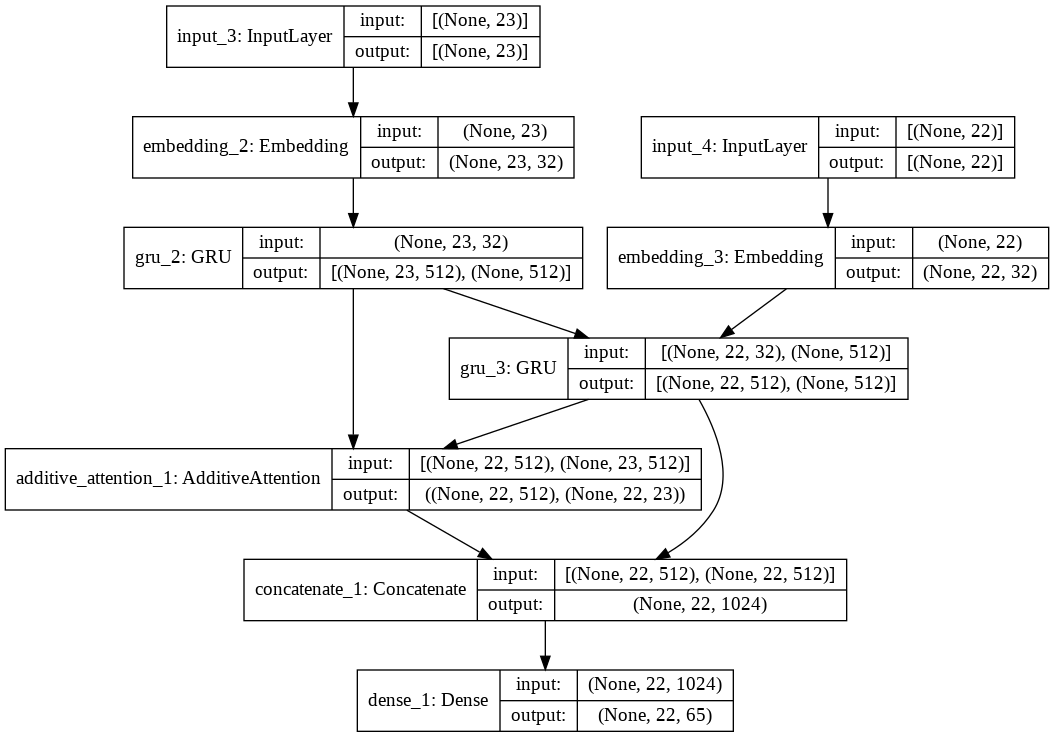

In [ ]:
plotModel(model)

**ONLY RUN THE CELL BELOW IF YOU WANT TO SEE TEST 
ACCURACY USING INFERENCE ; IT WILL TAKE CLOSE TO 20 MINUTES TO RUN**

In [ ]:
Test_Acc_With_Best_Model_In_Sweep()
WriteToCSVFile(arrays)

calculation of Test inference accuracy has started...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


so far accuracy =  0.502
so far accuracy =  0.5245245245245245
so far accuracy =  0.5540720961281709
so far accuracy =  0.5718577866800201
so far accuracy =  0.5713141025641025
test_inference_beam_acc 0.5708


**BELOW IS THE PREDICTION FOR A FEW TEST DATA IN 3x3 GRID**

In [ ]:
ip,prd,actual=[],[],[]
for seq_index in [2444, 449, 5, 1021, 2014, 784, 997, 981, 1090, 73, 85, 1884, 0, 700, 600, 850]:
    input_seq = encoder_input_test_data[seq_index : seq_index + 1]
    #print(input_seq)
    ignore = charByCharDecoding(input_seq) 
    a=""
    lst=[np.argmax(iii) for iii in beamMatrix]
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
    for i in lst:
      a+=reverse_target_char_index[i]
    ip.append(input_test_texts[seq_index].strip()); 
    prd.append(a.replace("\n","").strip()); 
    actual.append(target_test_texts[seq_index].strip())
from termcolor import colored
for i in range(4):
    print(colored("i/p:  "+ip[i*4+0]+"          i/p: "+ ip[i*4+1]+ "          i/p: "+ ip[i*4+2]+ "          i/p: "+ ip[i*4+3],  'red', attrs=['bold']))
    print(colored("pred: "+prd[i*4+0]+"           pred: "+prd[i*4+1]+ "           pred: "+ prd[i*4+2]+ "           pred: "+prd[i*4+3], 'blue', attrs=['bold']))
    print(colored("true: " +actual[i*4+0]+"           true: "+actual[i*4+1]+ "           true: "+ actual[i*4+2]+ "           true: "+actual[i*4+3],  'green', attrs=['bold']))

    print("\n\n\n")

i/p:  hakikat          i/p: kritika          i/p: angraji          i/p: dinaank
pred: हाकिकत           pred: कृतिका           pred: अंग्रजी           pred: दिनांक
true: हकीकत           true: कृतिका           true: अंग्रज़ी           true: दिनांक




i/p:  lenevali          i/p: junior          i/p: dastaanaa          i/p: thailee
pred: लेनेवाली           pred: जनियर           pred: दस्ताना           pred: थैली
true: लेनेवाली           true: जूनियर           true: दस्ताना           true: थैली




i/p:  naksalavaad          i/p: amarpaal          i/p: arabab          i/p: ramkot
pred: नकसलवाद           pred: अमरपाल           pred: अरबब           pred: रामकोट
true: नक्सलवाद           true: अमरपाल           true: अरबाब           true: रामकोट




i/p:  ank          i/p: chhupata          i/p: ghumakkadi          i/p: toka
pred: अंक           pred: छुपटा           pred: घुमक्कड़ी           pred: टोका
true: अंक           true: छुपता           true: घुमक्कड़ी           true: टोका






**BELOW HERE I SHOWED PREDICTIONS FOR CUSTOM WORDS THOSE ARE NOT IN TRAIN TEST OR VAL(DEV) DATASET**

In [ ]:
def wannaTry(check, a=""):
    encodd= np.ones((1, max_encoder_seq_length), dtype="float32"); space="                 "

    for i, input_text in enumerate(["\t"+check+"\n"]):
      for t, char in enumerate(input_text):
          encodd[i, t] =  input_token_index[char]

    ignore=charByCharDecoding(encodd)
    lst=[np.argmax(iii) for iii in beamMatrix]
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
    print(check.strip(), space, "".join([reverse_target_char_index[g] for g in lst]).replace("\n","").strip())

checks=["anshika", "gangwar","sayan", "chandra", "shivam", "varun", "amrita", "aanchal", "mayank", "mitesh", "khapra", "rahul", "bharat", "rasta"]
print("input word:         predicted word:")
print("-----------         ---------------")
for check in checks:
  wannaTry(check)

input word:         predicted word:
-----------         ---------------
anshika                   अंशिका
gangwar                   गंगवार
sayan                   सायन
chandra                   चंद्रा
shivam                   शिवम
varun                   वरुण
amrita                   अमृता
aanchal                   आंचल
mayank                   मायंक
mitesh                   मिटेश
khapra                   खपरा
rahul                   रहुल
bharat                   भरत
rasta                   रस्ता


**BELOW we download a TTF fine for hindi as in colab matplotlib.pyplot hindi charecters has some bug and it never appears while plotting**

In [ ]:
!wget "https://www.fontmirror.com/app_public/files/t/1/2020/04/MANGAL.TTF"

**Here we are giving attention heatmap of 9 words using seaborn in a 3X3 grid**

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


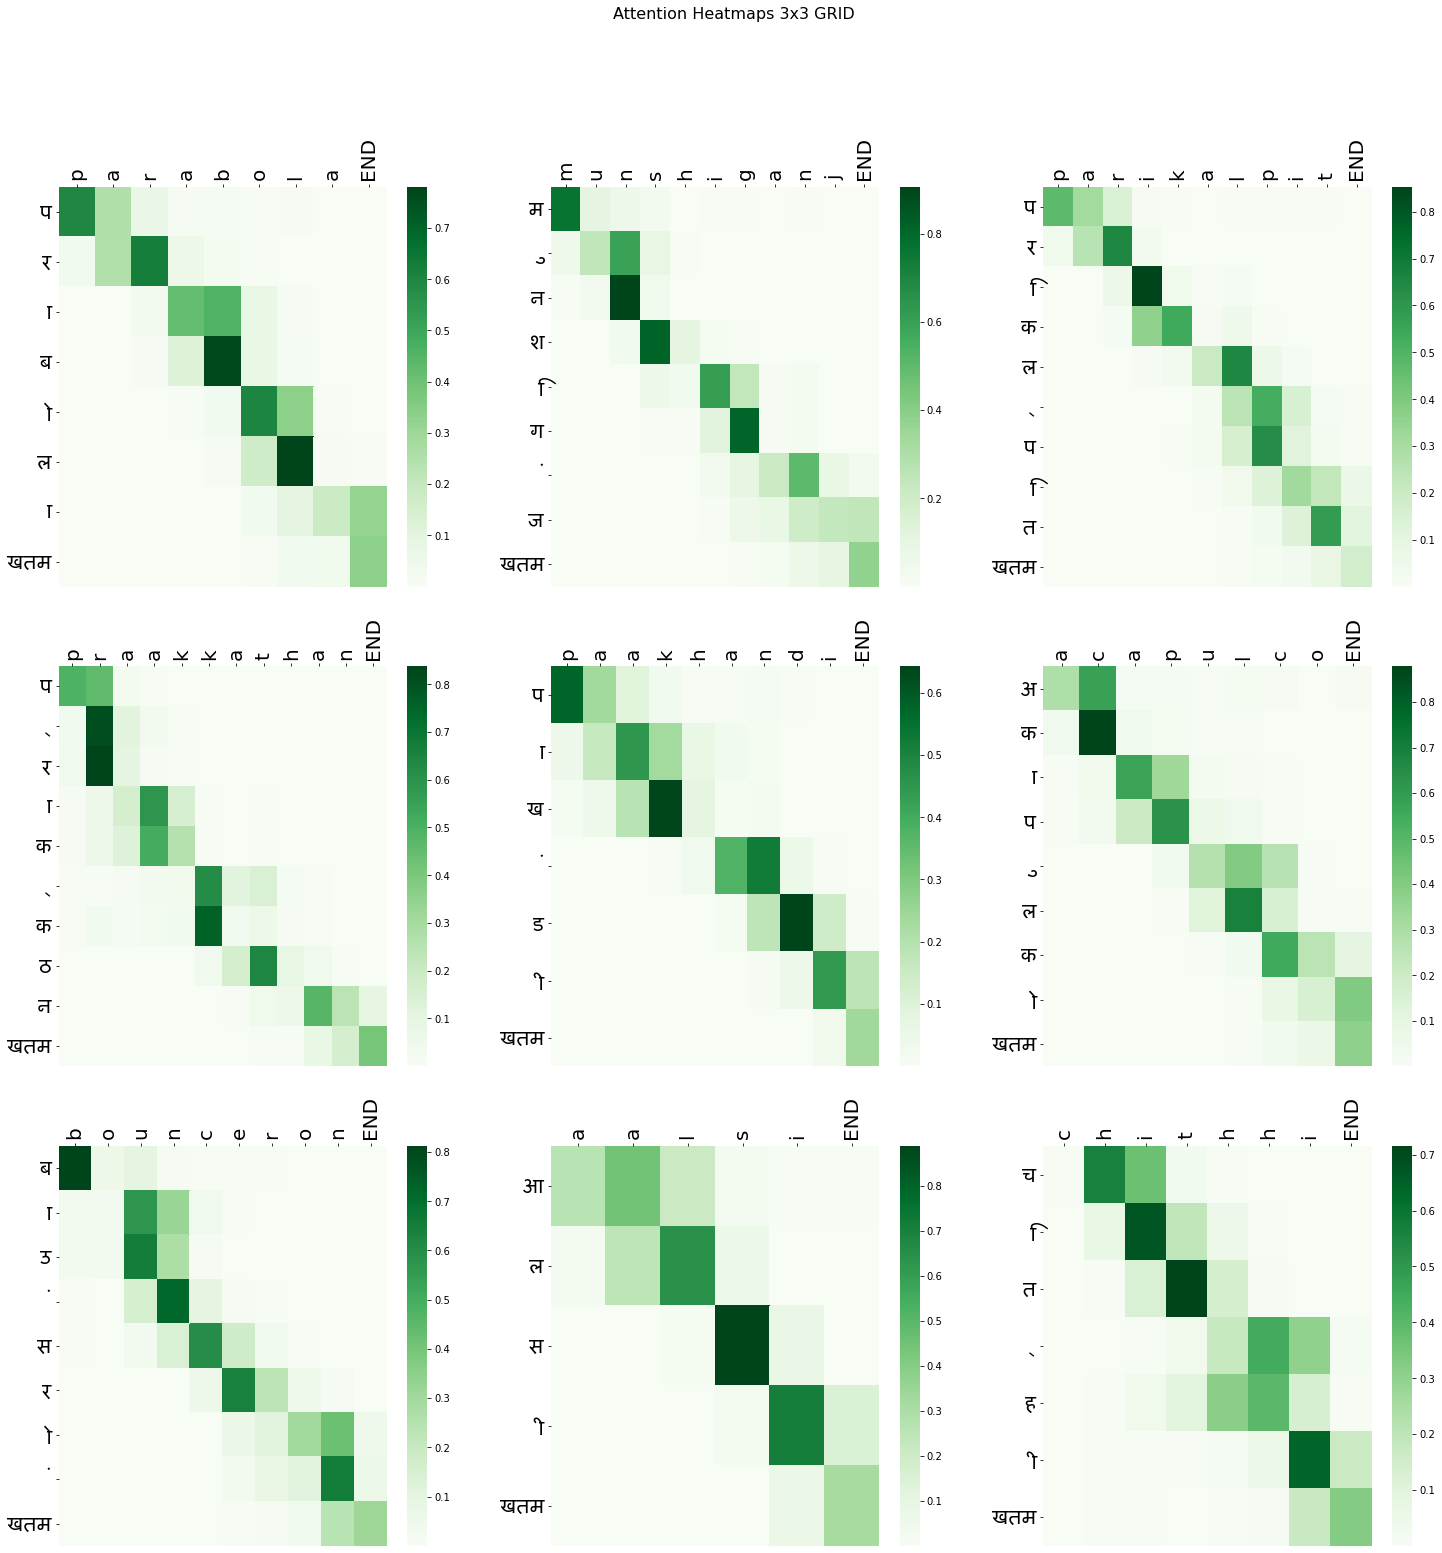

In [ ]:
import seaborn as ssss
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as setHindi
myfig = plt.figure(figsize=(25, 25))
myfig.suptitle('Attention Heatmaps 3x3 GRID', fontsize=16)
count=0
lenOfPred, lenOfActual=0,0
stringPred, stringActual="",""

def viz_Attention_Heatmaps(attentionOut, xx):    
    END=["END"]
    KHATAM=[reverse_target_char_index[18]+reverse_target_char_index[32]+reverse_target_char_index[41]]
    sub = myfig.add_subplot(3, 3, count)
    attentionOut=np.array(attentionOut)
    draw=ssss.heatmap(attentionOut[:, 2:lenOfActual+1], cmap="Greens")
    #print(list(stringActual), lenOfActual)
    draw.set_xticklabels( list(stringActual[1:-1]) + END, fontdict={'fontsize': 20}, rotation=90)
    draw.set_yticklabels( list(stringPred) + KHATAM, fontproperties=setHindi(fname='MANGAL.TTF', size=25), fontdict={'fontsize': 20}, rotation=0)
    draw.xaxis.tick_top()
    draw.xaxis.set_label_position("top")
#:lenOfPred+1, 1:lenOfActual+1



import random
samplee=random.sample(range(0, 2499), 50)
for seq_index in [1332, 1756, 1228, 1365, 1255, 14, 1517, 169, 652]:
    count+=1
    input_seq = encoder_input_test_data[seq_index : seq_index + 1]
    lenOfActual=len(input_test_texts[seq_index]); stringActual=input_test_texts[seq_index]
    ignore = charByCharDecoding(input_seq) 
    a=""
    lst=[np.argmax(iii) for iii in beamMatrix]
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
    for i in lst:
      a+=reverse_target_char_index[i]
    lenOfPred=len(a.replace("\n","").strip()); stringPred=a.replace("\n","").strip()
    viz_Attention_Heatmaps(attentionOut, seq_index) #predLen, pred, actualLen, actual

In [ ]:
lenOfPred, lenOfActual=0,0
stringPred, stringActual="",""



import random
samplee=random.sample(range(0, 2499), 50)
for seq_index in [1332]:
    count+=1
    input_seq = encoder_input_test_data[seq_index : seq_index + 1]
    lenOfActual=len(input_test_texts[seq_index]); stringActual=input_test_texts[seq_index]
    ignore = charByCharDecoding(input_seq) 
    a=""
    lst=[np.argmax(iii) for iii in beamMatrix]
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
    for i in lst:
      a+=reverse_target_char_index[i]
    lenOfPred=len(a.replace("\n","").strip()); stringPred=a.replace("\n","").strip()
    print(list(stringPred), lenOfPred, list(stringActual), lenOfActual)
    attnmtrx=np.array(attentionOut)[:, 2:lenOfActual+1]
stringActual, stringPred = stringActual[1:-1]+"_", stringPred[:-1]+"_"

['प', 'र', 'ा', 'ब', 'ो', 'ल', 'ा'] 7 ['\t', 'p', 'a', 'r', 'a', 'b', 'o', 'l', 'a', '\n'] 10


In [ ]:
attnmtrx, list(stringActual), list(stringPred)

**Below is the QUESTION 6 vizualization**

In [29]:
from IPython.display import HTML as html_print
from IPython.display import display
from IPython.display import display, clear_output
import time




def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]


def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)



def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))
 
  
  
def visualize(output_values, result_list, cell_no):
    print("Input Word : "+"".join(stringActual))
    print("Predicted Word : "+"".join(stringPred))
    print(stringPred[cell_no])
    text_colours = []
    for i in range(len(stringActual)):
      text = (result_list[i], get_clr(output_values[cell_no][i]))
      text_colours.append(text)
    print_color(text_colours)
 


cell_no=0
lll=len(stringPred)
time.sleep(10)
while 1:
 # 0,1,2,3,4, 0, ..
 visualize(attnmtrx[:], "".join(stringActual), cell_no)
 cell_no=(cell_no+1)%lll
 time.sleep(2)
 clear_output()

Input Word : parabola_
Predicted Word : पराबोला_
ब


KeyboardInterrupt: ignored